In [1121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn import preprocessing
from datetime import datetime
from scipy import stats

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.3f}'.format

In [1122]:
# 1- read data file
raw_data_file_path = '../data-2/all-data-run2.csv'
raw_df = pd.read_csv(raw_data_file_path, header=None, skiprows=1, names=['metric', 'date', 'value'])

raw_df.date = pd.to_datetime(raw_df.date)
raw_df.value = pd.to_numeric(raw_df.value)
raw_df.set_index('date', inplace=True)

### Read the raw data. 

All data is in one file, where each metric is listed under each other with three columns: 

1- metric: The name of the metric

2- date: the data and time of the metric

3- value: the metric value


### Put each metric into a separate dataframe

In [1123]:
#- metrics raw data
svc_cpu_use = raw_df.loc[raw_df['metric'] == 'svc_cpu_use'].drop('metric', 1).rename(columns={"value": "svc_cpu_use"})
svc_cpu_sat = raw_df.loc[raw_df['metric'] == 'svc_cpu_sat'].drop('metric', 1).rename(columns={"value": "svc_cpu_thr"})
svc_net_use = raw_df.loc[raw_df['metric'] == 'svc_net_use'].drop('metric', 1).rename(columns={"value": "svc_net_use"}) / (1024 * 1024)
svc_disk_use = raw_df.loc[raw_df['metric'] == 'svc_disk_use'].drop('metric', 1).rename(columns={"value": "svc_disk_use"}) / (1024 * 1024)
system_cpu_use = raw_df.loc[raw_df['metric'] == 'system_cpu_use'].drop('metric', 1).rename(columns={"value": "system_cpu_use"})
system_cpu_sat = raw_df.loc[raw_df['metric'] == 'system_cpu_sat'].drop('metric', 1).rename(columns={"value": "system_cpu_sat"}) / 60
system_net_use = raw_df.loc[raw_df['metric'] == 'system_net_use'].drop('metric', 1).rename(columns={"value": "system_net_use"}) / (1024 * 1024)
system_net_sat = raw_df.loc[raw_df['metric'] == 'system_net_sat'].drop('metric', 1).rename(columns={"value": "system_net_sat"})
system_disk_sat = raw_df.loc[raw_df['metric'] == 'system_disk_sat'].drop('metric', 1).rename(columns={"value": "system_disk_sat"})
system_disk_io = raw_df.loc[raw_df['metric'] == 'system_disk_io'].drop('metric', 1).rename(columns={"value": "system_disk_io"})
svc_req_size = raw_df.loc[raw_df['metric'] == 'svc_req_size'].drop('metric', 1).rename(columns={"value": "svc_req_size"}) / (1024 * 1024)
svc_resp_size = raw_df.loc[raw_df['metric'] == 'svc_resp_size'].drop('metric', 1).rename(columns={"value": "svc_resp_size"}) / (1024 * 1024)
svc_pods = raw_df.loc[raw_df['metric'] == 'svc_pods'].drop('metric', 1).rename(columns={"value": "svc_pods"})
svc_req_rate = raw_df.loc[raw_df['metric'] == 'svc_req_rate'].drop('metric', 1).rename(columns={"value": "svc_req_rate"})
#svc_ltcy = raw_df.loc[raw_df['metric'] == 'svc_ltcy'].drop('metric', 1).rename(columns={"value": "ltcy"})
svc_ltcy_200 = raw_df.loc[raw_df['metric'] == 'svc_ltcy_200'].drop('metric', 1).rename(columns={"value": "ltcy"})


In [1124]:
#- merge metrics features together along with latency
merg_1 = pd.merge_asof(svc_cpu_use, svc_cpu_sat, left_index=True, right_index=True, tolerance=pd.Timedelta('15 second')).fillna(np.nan)
merg_2 = pd.merge_asof(merg_1, svc_net_use, left_index=True, right_index=True, tolerance=pd.Timedelta('15 second')).fillna(np.nan)
merg_3 = pd.merge_asof(merg_2, svc_disk_use, left_index=True, right_index=True, tolerance=pd.Timedelta('15 second')).fillna(np.nan)
merg_4 = pd.merge_asof(merg_3, system_cpu_use, left_index=True, right_index=True, tolerance=pd.Timedelta('15 second')).fillna(np.nan)
merg_5 = pd.merge_asof(merg_4, system_cpu_sat, left_index=True, right_index=True, tolerance=pd.Timedelta('15 second')).fillna(np.nan)
merg_6 = pd.merge_asof(merg_5, system_net_use, left_index=True, right_index=True, tolerance=pd.Timedelta('15 second')).fillna(np.nan)
merg_7 = pd.merge_asof(merg_6, system_net_sat, left_index=True, right_index=True, tolerance=pd.Timedelta('15 second')).fillna(np.nan)
merg_8 = pd.merge_asof(merg_7, system_disk_sat, left_index=True, right_index=True, tolerance=pd.Timedelta('15 second')).fillna(np.nan)
merg_9 = pd.merge_asof(merg_8, system_disk_io, left_index=True, right_index=True, tolerance=pd.Timedelta('15 second')).fillna(np.nan)
merg_10 = pd.merge_asof(merg_9, svc_req_size, left_index=True, right_index=True, tolerance=pd.Timedelta('15 second')).fillna(np.nan)
merg_11 = pd.merge_asof(merg_10, svc_resp_size, left_index=True, right_index=True, tolerance=pd.Timedelta('15 second')).fillna(np.nan)
merg_12 = pd.merge_asof(merg_11, svc_pods, left_index=True, right_index=True, tolerance=pd.Timedelta('15 second')).fillna(np.nan)
merg_13 = pd.merge_asof(merg_12, svc_req_rate, left_index=True, right_index=True, tolerance=pd.Timedelta('15 second')).fillna(np.nan)
raw_data = pd.merge_asof(merg_13, svc_ltcy_200, left_index=True, right_index=True, tolerance=pd.Timedelta('15 second')).fillna(np.nan)

# consider only rows with latency is not null
raw_data = raw_data[raw_data['ltcy'].notna()]

# remove timestamp index
raw_data.reset_index(drop=True, inplace=True)

raw_data.shape

(2791, 15)

### Examine the data

In [1125]:
raw_data.describe(include="all")

,svc_cpu_use,svc_cpu_thr,svc_net_use,svc_disk_use,system_cpu_use,system_cpu_sat,system_net_use,system_net_sat,system_disk_sat,system_disk_io,svc_req_size,svc_resp_size,svc_pods,svc_req_rate,ltcy
count,"2,791.000","2,791.000","2,788.000","2,791.000","2,572.000","2,596.000","2,565.000","2,597.000","2,571.000","2,571.000","2,791.000","2,791.000","2,791.000","2,555.000","2,791.000"
mean,1.835,0.544,0.846,0.280,8.221,4.151,16.070,0.000,0.980,0.073,0.027,0.179,15.217,21.690,1.075
std,0.727,0.421,0.389,0.483,2.296,1.607,5.220,0.000,0.000,0.419,0.012,0.118,7.268,8.636,1.435
min,0.110,0.000,0.028,0.000,1.940,0.836,2.864,0.000,0.980,0.000,0.000,0.000,2.000,0.200,0.110
25%,1.290,0.230,0.518,0.036,6.825,2.835,12.973,0.000,0.980,0.010,0.018,0.042,10.000,16.545,0.480
50%,1.810,0.410,0.852,0.070,8.495,4.448,16.392,0.000,0.980,0.020,0.027,0.207,15.000,23.310,0.740
75%,2.360,0.790,1.142,0.134,9.650,5.401,20.796,0.000,0.980,0.020,0.036,0.272,18.000,27.455,0.970
max,3.430,2.050,1.844,3.269,12.590,7.492,25.031,0.000,0.980,7.130,0.055,0.382,35.000,36.710,9.970


### Check missing values

In [1126]:
# percent of missing value for every feature
raw_data.isnull().sum() * 100 / raw_data.shape[0]

svc_cpu_use       0.000
svc_cpu_thr       0.000
svc_net_use       0.107
svc_disk_use      0.000
system_cpu_use    7.847
system_cpu_sat    6.987
system_net_use    8.097
system_net_sat    6.951
system_disk_sat   7.882
system_disk_io    7.882
svc_req_size      0.000
svc_resp_size     0.000
svc_pods          0.000
svc_req_rate      8.456
ltcy              0.000
dtype: float64

missing data on every variable is < 15%, any impuation method would be fine, I would choose a linear impuation method

In [1127]:
# because missing percentages are < 15%, we can go ahead and remedy them without checking more on the effect of missing
# values 
# we can use linear interpolation as immutation method to fill in missing values
raw_data = raw_data.interpolate(method='linear', inplace=False)

# Note no more missing values
raw_data.isnull().sum() * 100 / raw_data.shape[0]

svc_cpu_use       0.000
svc_cpu_thr       0.000
svc_net_use       0.000
svc_disk_use      0.000
system_cpu_use    0.000
system_cpu_sat    0.000
system_net_use    0.000
system_net_sat    0.000
system_disk_sat   0.000
system_disk_io    0.000
svc_req_size      0.000
svc_resp_size     0.000
svc_pods          0.000
svc_req_rate      0.000
ltcy              0.000
dtype: float64

### Outliers

###### latency target 

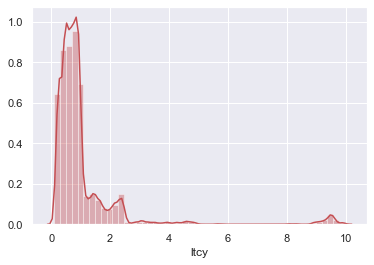

In [1128]:
sns.distplot(raw_data['ltcy'], hist=True, rug=False, color="r", label='ltcy')

Minimum value of ltcy is 0.11, mean 1.092, 25% < 0.47, 50% < 0.68, 75% < 0.92 and the maximum jumps up to 10. Looks like values are around 1 where 75% of values are very close to one, and there are values have big jump to a 10. The outliers are aparent (as shown in the graph above as well).

There are two ways we can remedy outlier with. One way is to standarize the latency values and consider removing observations with values > (+/-) 4 (conventional rule for data sample > 200), or take out values fall less than 99 percentile. We will choose the first option.

In [1129]:
# Create the Scaler object
scaler = preprocessing.StandardScaler()

if 1 == 0:
    raw_ltcy = raw_data['ltcy']

    # Fit your data on the scaler object
    scaled_ltcy = scaler.fit_transform(raw_ltcy.values.reshape(-1,1))
    scaled_ltcy = pd.DataFrame(scaled_ltcy, columns=['scaled_ltcy'])
    
    raw_data = pd.concat([raw_data, scaled_ltcy['scaled_ltcy'].abs()], axis=1)
    #raw_data['scaled_ltcy'] = scaled_ltcy['scaled_ltcy'].abs()
    
    raw_data = raw_data[raw_data['scaled_ltcy'] < 4]
    sns.distplot(raw_data['ltcy'])

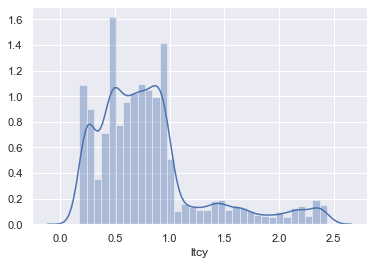

In [1130]:
# option 2: consider lower 99 percentile of the ltcy values

if 1 == 1:
    q = raw_data['ltcy'].quantile(0.95)
    raw_data = raw_data[raw_data['ltcy'] < q]
    raw_data
    sns.distplot(raw_data['ltcy'])

The scaled latency distribution shows now an exponential graph. Taking the log and plotting it would remedy the skewness.

In [1131]:
# TODO: put this down in the normalization transformation section
#log_ltcy = np.log(raw_data.ltcy)

#raw_data['log_ltcy'] = log_ltcy
# create new normalized_data dataframe
#normalized_data = pd.DataFrame(log_ltcy, columns=['ltcy'])

#sns.distplot(normalized_data['ltcy'])

for now take away the outliers on pods as well. 

TODO: Please add data to consider 3 and 4 number of pods per service with number of users up to 300 and 400 respectively 

In [1132]:
if 1 == 0:  # not using this , use the one below
    raw_svc_pods = raw_data['svc_pods']

    # Fit your data on the scaler object
    scaled_svc_pods = scaler.fit_transform(raw_svc_pods.values.reshape(-1,1))
    scaled_svc_pods = pd.DataFrame(scaled_svc_pods, columns=['scaled_svc_pods'])

    raw_data['scaled_svc_pods'] = scaled_svc_pods['scaled_svc_pods'].abs()
    raw_data = raw_data[raw_data['scaled_svc_pods'] < 4]
    sns.distplot(raw_data['svc_pods'])

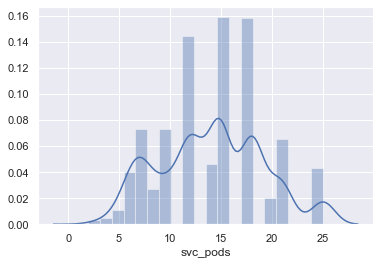

In [1133]:
# I am using this opion 2: consider lower 99 percentile of the pods values
if 1 == 1:  
    q = raw_data['svc_pods'].quantile(0.95)
    raw_data = raw_data[raw_data['svc_pods'] < q]
    sns.distplot(raw_data['svc_pods'])

In [1134]:
raw_data.describe()

,svc_cpu_use,svc_cpu_thr,svc_net_use,svc_disk_use,system_cpu_use,system_cpu_sat,system_net_use,system_net_sat,system_disk_sat,system_disk_io,svc_req_size,svc_resp_size,svc_pods,svc_req_rate,ltcy
count,"2,407.000","2,407.000","2,407.000","2,407.000","2,407.000","2,407.000","2,407.000","2,407.000","2,407.000","2,407.000","2,407.000","2,407.000","2,407.000","2,407.000","2,407.000"
mean,1.795,0.528,0.823,0.264,8.070,4.101,15.829,0.000,0.980,0.072,0.026,0.173,14.059,21.457,0.817
std,0.714,0.390,0.392,0.471,2.101,1.549,5.319,0.000,0.000,0.400,0.012,0.119,5.115,8.982,0.514
min,0.110,0.000,0.028,0.000,1.940,0.836,2.864,0.000,0.980,0.000,0.000,0.001,2.000,0.200,0.110
25%,1.270,0.220,0.494,0.034,7.185,2.897,12.495,0.000,0.980,0.010,0.017,0.036,10.000,15.825,0.470
50%,1.770,0.430,0.824,0.067,8.470,4.410,16.329,0.000,0.980,0.020,0.026,0.193,15.000,22.530,0.720
75%,2.310,0.780,1.128,0.124,9.500,5.304,20.390,0.000,0.980,0.020,0.035,0.268,18.000,27.455,0.950
max,3.430,1.620,1.844,3.269,12.360,7.492,25.031,0.000,0.980,7.130,0.055,0.382,25.000,36.710,2.440


In [1135]:
raw_data.shape

(2407, 15)

### Check Regression Assumptions

#### 1- Normality

Examining the Normal Probability Distribution for the rest of the variables (latency already normalized using a visual look to the distribution graph above)

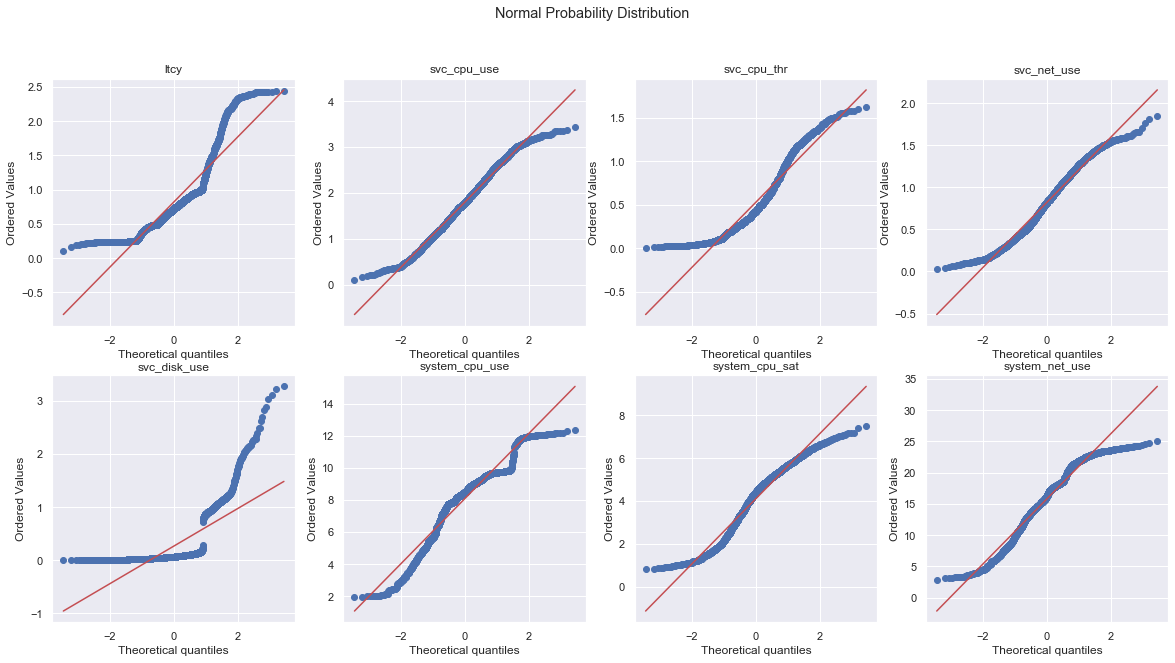

In [1136]:
fig, ax = plt.subplots(2,4,figsize=(20,10))

# log_ltcy should look ok as its transformed above
stats.probplot(raw_data['ltcy'], plot=ax[0,0])
ax[0, 0].set_title('ltcy')

stats.probplot(raw_data['svc_cpu_use'], plot=ax[0,1])
ax[0, 1].set_title('svc_cpu_use')

stats.probplot(raw_data['svc_cpu_thr'], plot=ax[0,2])
ax[0, 2].set_title('svc_cpu_thr')

stats.probplot(raw_data['svc_net_use'], plot=ax[0,3])
ax[0, 3].set_title('svc_net_use')

stats.probplot(raw_data['svc_disk_use'], plot=ax[1,0])
ax[1, 0].set_title('svc_disk_use')

stats.probplot(raw_data['system_cpu_use'], plot=ax[1,1])
ax[1, 1].set_title('system_cpu_use')

stats.probplot(raw_data['system_cpu_sat'], plot=ax[1,2])
ax[1, 2].set_title('system_cpu_sat')

stats.probplot(raw_data['system_net_use'], plot=ax[1,3])
ax[1, 3].set_title('system_net_use')



fig.suptitle('Normal Probability Distribution')
plt.show()

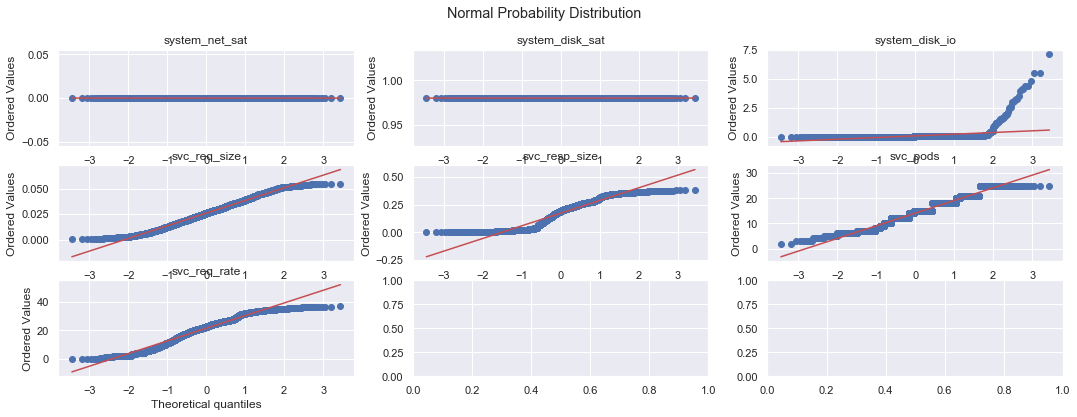

In [1137]:
fig, ax = plt.subplots(3,3,figsize=(18,6))

stats.probplot(raw_data['system_net_sat'], plot=ax[0,0])
ax[0, 0].set_title('system_net_sat')

stats.probplot(raw_data['system_disk_sat'], plot=ax[0,1])
ax[0, 1].set_title('system_disk_sat')

stats.probplot(raw_data['system_disk_io'], plot=ax[0,2])
ax[0, 2].set_title('system_disk_io')

stats.probplot(raw_data['svc_req_size'], plot=ax[1,0])
ax[1, 0].set_title('svc_req_size')

stats.probplot(raw_data['svc_resp_size'], plot=ax[1,1])
ax[1, 1].set_title('svc_resp_size')

stats.probplot(raw_data['svc_pods'], plot=ax[1,2])
ax[1, 2].set_title('svc_pods')

stats.probplot(raw_data['svc_req_rate'], plot=ax[2,0])
ax[2, 0].set_title('svc_req_rate')

fig.suptitle('Normal Probability Distribution')
plt.show()

above Normal Probability Plots (MPP) illustrates so low variance for "system_net_sat", "system_disk_sat" and "system_disk_io" variables. Apparently, the system network and disk saturation are not affected when applying different loads to the application. We will drop these varibles and not consider them.

In [1138]:
raw_data = raw_data.drop('system_net_sat', 1)
raw_data = raw_data.drop('system_disk_sat', 1)
raw_data = raw_data.drop('system_disk_io', 1)

###### Normalization Remedy Transformation

In [1139]:
# create a new dataframe
normalized_data = pd.DataFrame()

Text(0.5, 1.0, 'ltcy NPP')

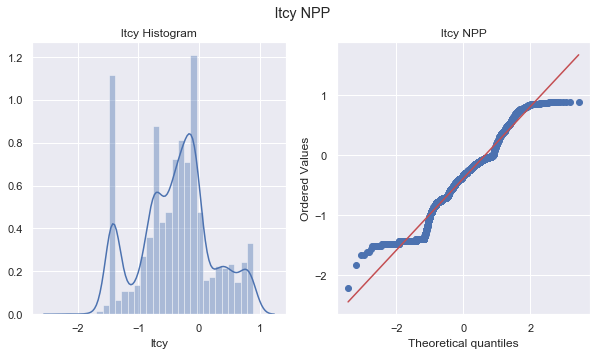

In [1140]:
# svc_ltcy 
normalized_data['ltcy'] = np.log(raw_data.ltcy)

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('ltcy NPP')

sns.distplot(normalized_data['ltcy'], ax=ax[0])
ax[0].set_title('ltcy Histogram')
stats.probplot(normalized_data['ltcy'], plot=ax[1])
ax[1].set_title('ltcy NPP')

Text(0.5, 1.0, 'svc_cpu_use NPP')

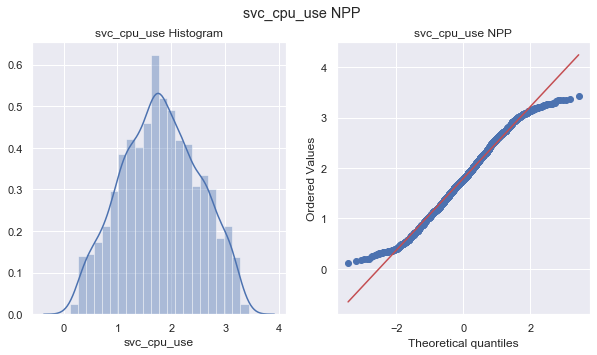

In [1141]:
# svc_cpu_use: looks ok
normalized_data['svc_cpu_use'] = raw_data.svc_cpu_use

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('svc_cpu_use NPP')

sns.distplot(normalized_data['svc_cpu_use'], ax=ax[0])
ax[0].set_title('svc_cpu_use Histogram')
stats.probplot(normalized_data['svc_cpu_use'], plot=ax[1])
ax[1].set_title('svc_cpu_use NPP')

Text(0.5, 1.0, 'svc_cpu_thr NPP')

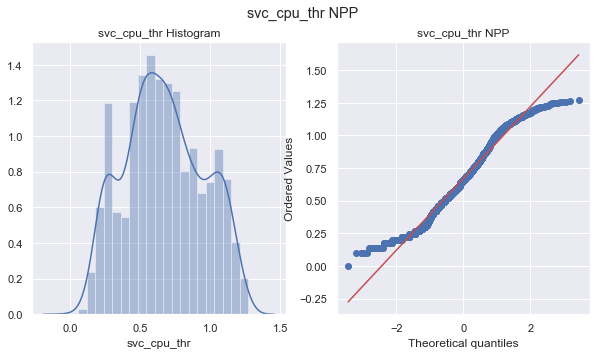

In [1142]:
# svc_cpu_use: 
normalized_data['svc_cpu_thr'] = np.sqrt(raw_data.svc_cpu_thr)

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('svc_cpu_thr NPP')

sns.distplot(normalized_data['svc_cpu_thr'], ax=ax[0])
ax[0].set_title('svc_cpu_thr Histogram')
stats.probplot(normalized_data['svc_cpu_thr'], plot=ax[1])
ax[1].set_title('svc_cpu_thr NPP')

Text(0.5, 1.0, 'svc_net_use NPP')

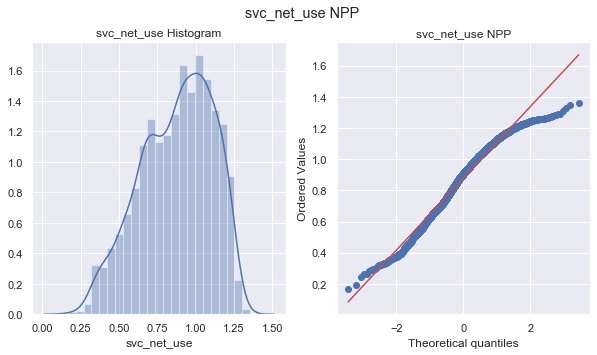

In [1143]:
# svc_net_use: 
normalized_data['svc_net_use'] = np.sqrt(raw_data.svc_net_use)

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('svc_net_use NPP')

sns.distplot(normalized_data['svc_net_use'], ax=ax[0])
ax[0].set_title('svc_net_use Histogram')
stats.probplot(normalized_data['svc_net_use'], plot=ax[1])
ax[1].set_title('svc_net_use NPP')


Text(0.5, 1.0, 'svc_disk_use NPP')

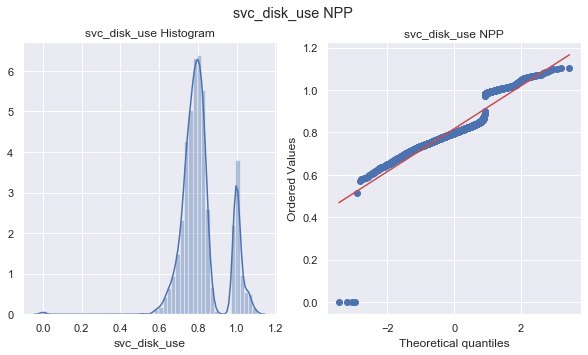

In [1144]:
# svc_disk_use: 
#normalized_data['svc_disk_use'] = raw_data.svc_disk_use
normalized_data['svc_disk_use'] = np.power(raw_data.svc_disk_use, 1/12)
#normalized_data['svc_disk_use'] = np.power(normalized_data.svc_disk_use, 3)

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('svc_disk_use NPP')

sns.distplot(normalized_data['svc_disk_use'], ax=ax[0])
ax[0].set_title('svc_disk_use Histogram')
stats.probplot(normalized_data['svc_disk_use'], plot=ax[1])
ax[1].set_title('svc_disk_use NPP')

Text(0.5, 1.0, 'system_cpu_use NPP')

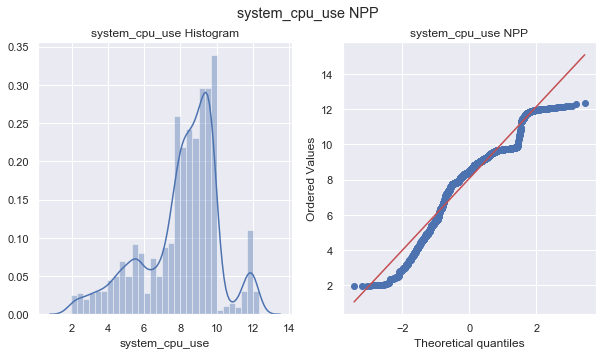

In [1145]:
# system_cpu_use: looks ok, does not need a transformation
normalized_data['system_cpu_use'] = raw_data.system_cpu_use

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('system_cpu_use NPP')

sns.distplot(normalized_data['system_cpu_use'], ax=ax[0])
ax[0].set_title('system_cpu_use Histogram')
stats.probplot(normalized_data['system_cpu_use'], plot=ax[1])
ax[1].set_title('system_cpu_use NPP')

Text(0.5, 1.0, 'system_cpu_sat NPP')

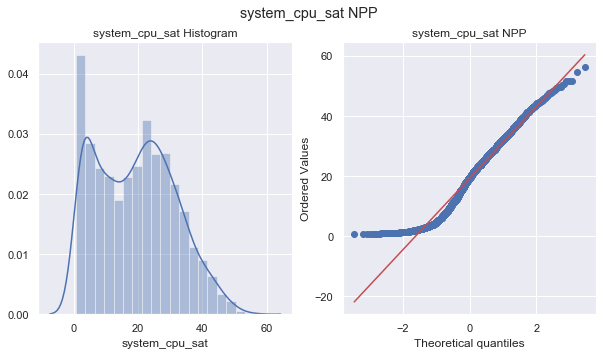

In [1146]:
# svc_disk_sat: 
normalized_data['system_cpu_sat'] = np.power(raw_data.system_cpu_sat, 2)  ## for run2
#normalized_data['system_cpu_sat'] = np.sqrt(raw_data.system_cpu_sat)
#normalized_data['system_cpu_sat'] = np.power(normalized_data.system_cpu_sat, 2)

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('system_cpu_sat NPP')

sns.distplot(normalized_data['system_cpu_sat'], ax=ax[0])
ax[0].set_title('system_cpu_sat Histogram')
stats.probplot(normalized_data['system_cpu_sat'], plot=ax[1])
ax[1].set_title('system_cpu_sat NPP')

Text(0.5, 1.0, 'system_net_use NPP')

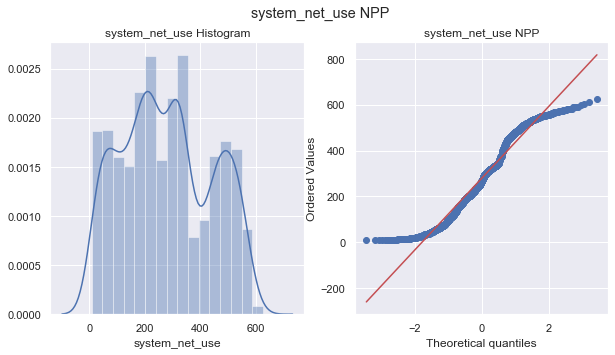

In [1147]:
# system_net_use: 
normalized_data['system_net_use'] = np.power(raw_data.system_net_use, 2) # for run2

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('system_net_use NPP')

sns.distplot(normalized_data['system_net_use'], ax=ax[0])
ax[0].set_title('system_net_use Histogram')
stats.probplot(normalized_data['system_net_use'], plot=ax[1])
ax[1].set_title('system_net_use NPP')

Text(0.5, 1.0, 'svc_req_size NPP')

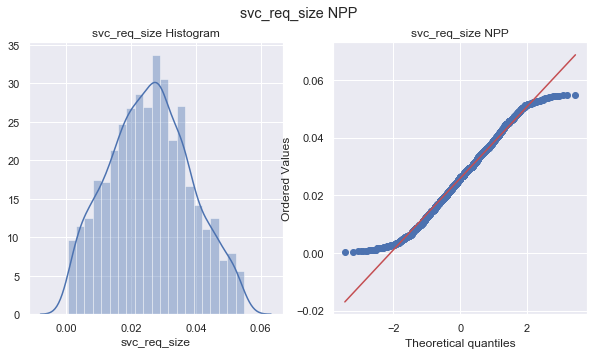

In [1148]:
# svc_req_size: look ok
normalized_data['svc_req_size'] = raw_data.svc_req_size

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('svc_req_size NPP')

sns.distplot(normalized_data['svc_req_size'], ax=ax[0])
ax[0].set_title('svc_req_size Histogram')
stats.probplot(normalized_data['svc_req_size'], plot=ax[1])
ax[1].set_title('svc_req_size NPP')

Text(0.5, 1.0, 'svc_resp_size NPP')

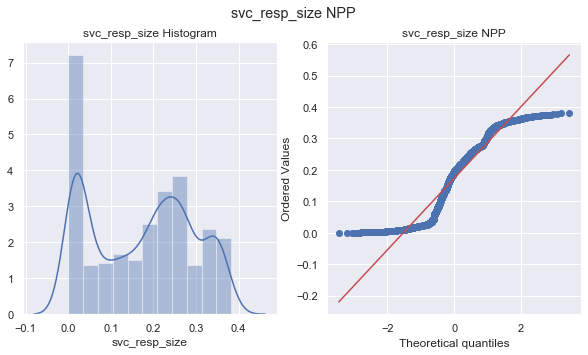

In [1149]:
# svc_resp_size: 
normalized_data['svc_resp_size'] = raw_data.svc_resp_size

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('svc_resp_size NPP')

sns.distplot(normalized_data['svc_resp_size'], ax=ax[0])
ax[0].set_title('svc_resp_size Histogram')
stats.probplot(normalized_data['svc_resp_size'], plot=ax[1])
ax[1].set_title('svc_resp_size NPP')

Text(0.5, 1.0, 'svc_pods NPP')

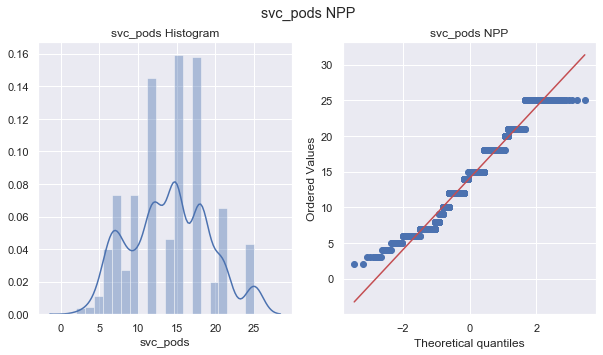

In [1150]:
# svc_pods: 
normalized_data['svc_pods'] = raw_data.svc_pods

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('svc_pods NPP')

sns.distplot(normalized_data['svc_pods'], ax=ax[0])
ax[0].set_title('svc_pods Histogram')
stats.probplot(normalized_data['svc_pods'], plot=ax[1])
ax[1].set_title('svc_pods NPP')

Text(0.5, 1.0, 'svc_req_rate NPP')

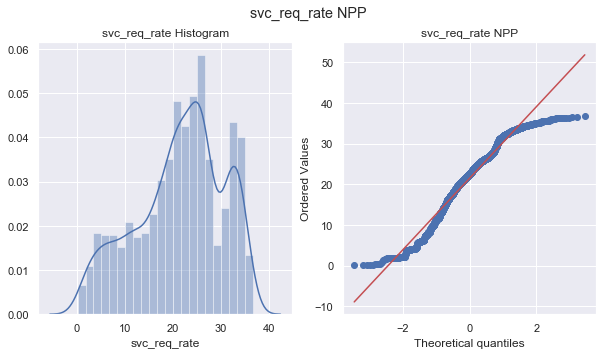

In [1151]:
# svc_pods: 
normalized_data['svc_req_rate'] = raw_data.svc_req_rate

fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('svc_req_rate NPP')

sns.distplot(normalized_data['svc_req_rate'], ax=ax[0])
ax[0].set_title('svc_req_rate Histogram')
stats.probplot(normalized_data['svc_req_rate'], plot=ax[1])
ax[1].set_title('svc_req_rate NPP')

In [1152]:
normalized_data.describe()

,ltcy,svc_cpu_use,svc_cpu_thr,svc_net_use,svc_disk_use,system_cpu_use,system_cpu_sat,system_net_use,svc_req_size,svc_resp_size,svc_pods,svc_req_rate
count,"2,407.000","2,407.000","2,407.000","2,407.000","2,407.000","2,407.000","2,407.000","2,407.000","2,407.000","2,407.000","2,407.000","2,407.000"
mean,-0.382,1.795,0.671,0.877,0.817,8.070,19.221,278.841,0.026,0.173,14.059,21.457
std,0.606,0.714,0.278,0.233,0.108,2.101,12.143,159.439,0.012,0.119,5.115,8.982
min,-2.207,0.110,0.000,0.166,0.000,1.940,0.699,8.203,0.000,0.001,2.000,0.200
25%,-0.755,1.270,0.469,0.703,0.754,7.185,8.390,156.120,0.017,0.036,10.000,15.825
50%,-0.329,1.770,0.656,0.908,0.798,8.470,19.445,266.640,0.026,0.193,15.000,22.530
75%,-0.051,2.310,0.883,1.062,0.840,9.500,28.129,415.752,0.035,0.268,18.000,27.455
max,0.892,3.430,1.273,1.358,1.104,12.360,56.125,626.567,0.055,0.382,25.000,36.710


###### ------------------ --------------------------- ------------------------ --------------------------

In [1153]:
normalized_data.describe()

,ltcy,svc_cpu_use,svc_cpu_thr,svc_net_use,svc_disk_use,system_cpu_use,system_cpu_sat,system_net_use,svc_req_size,svc_resp_size,svc_pods,svc_req_rate
count,"2,407.000","2,407.000","2,407.000","2,407.000","2,407.000","2,407.000","2,407.000","2,407.000","2,407.000","2,407.000","2,407.000","2,407.000"
mean,-0.382,1.795,0.671,0.877,0.817,8.070,19.221,278.841,0.026,0.173,14.059,21.457
std,0.606,0.714,0.278,0.233,0.108,2.101,12.143,159.439,0.012,0.119,5.115,8.982
min,-2.207,0.110,0.000,0.166,0.000,1.940,0.699,8.203,0.000,0.001,2.000,0.200
25%,-0.755,1.270,0.469,0.703,0.754,7.185,8.390,156.120,0.017,0.036,10.000,15.825
50%,-0.329,1.770,0.656,0.908,0.798,8.470,19.445,266.640,0.026,0.193,15.000,22.530
75%,-0.051,2.310,0.883,1.062,0.840,9.500,28.129,415.752,0.035,0.268,18.000,27.455
max,0.892,3.430,1.273,1.358,1.104,12.360,56.125,626.567,0.055,0.382,25.000,36.710


### Checking Regression (OLS) assumptions

In [1154]:
variables = normalized_data.columns.values
for var in variables:
    print(var)

ltcy
svc_cpu_use
svc_cpu_thr
svc_net_use
svc_disk_use
system_cpu_use
system_cpu_sat
system_net_use
svc_req_size
svc_resp_size
svc_pods
svc_req_rate


Plat every variable against the latency 

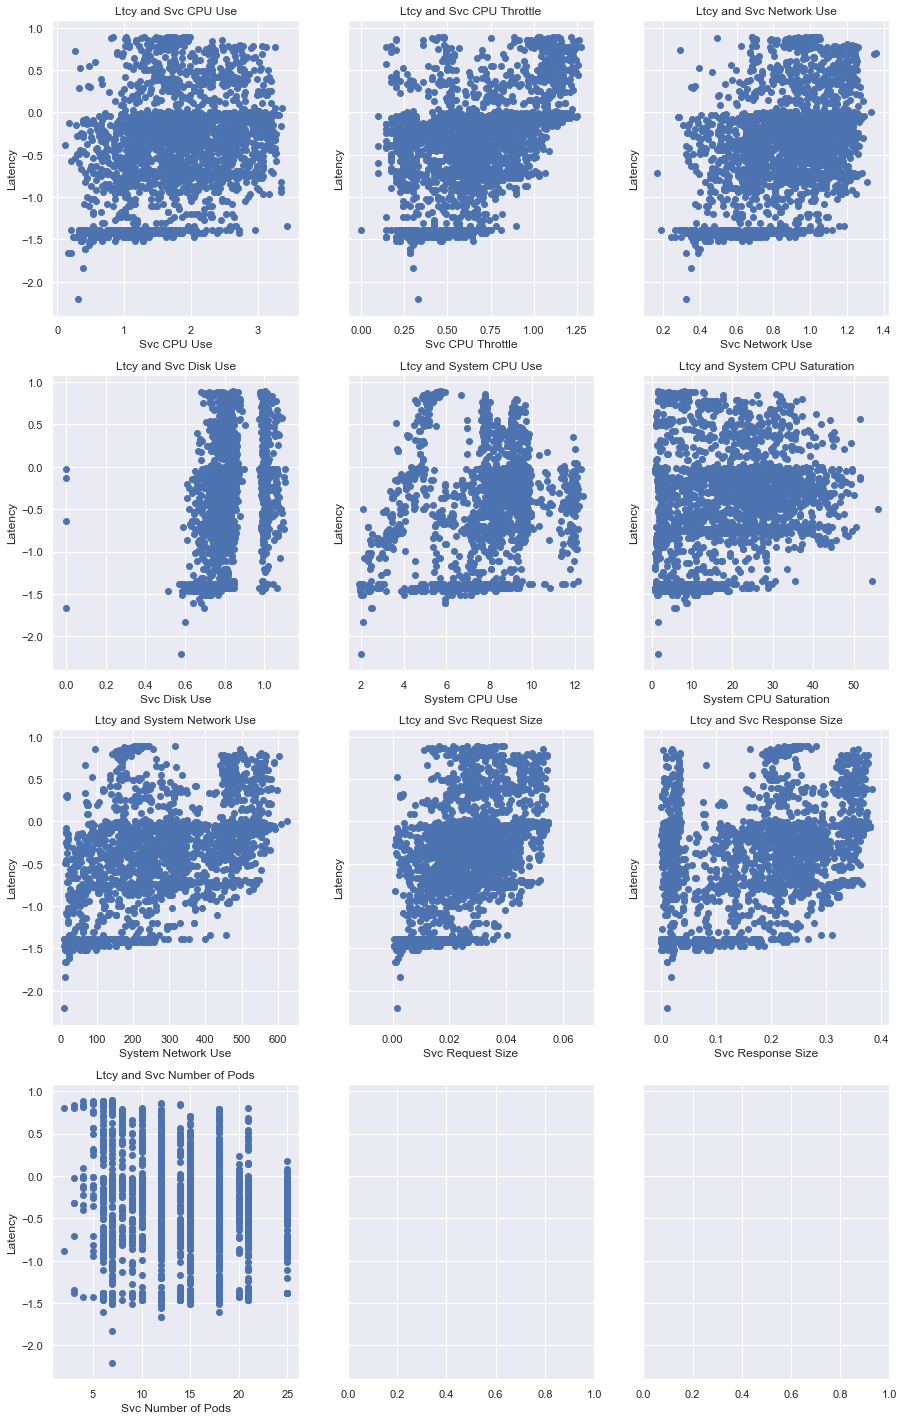

In [1155]:
f, ax = plt.subplots(4, 3, sharey=True, figsize = (15,25))

ax[0,0].scatter(normalized_data['svc_cpu_use'], normalized_data['ltcy'])
ax[0,0].set_title('Ltcy and Svc CPU Use')
ax[0,0].set_xlabel('Svc CPU Use')
ax[0,0].set_ylabel('Latency')

ax[0,1].scatter(normalized_data['svc_cpu_thr'], normalized_data['ltcy'])
ax[0,1].set_title('Ltcy and Svc CPU Throttle')
ax[0,1].set_xlabel('Svc CPU Throttle')
ax[0,1].set_ylabel('Latency')

ax[0,2].scatter(normalized_data['svc_net_use'], normalized_data['ltcy'])
ax[0,2].set_title('Ltcy and Svc Network Use')
ax[0,2].set_xlabel('Svc Network Use')
ax[0,2].set_ylabel('Latency')

ax[1,0].scatter(normalized_data['svc_disk_use'], normalized_data['ltcy'])
ax[1,0].set_title('Ltcy and Svc Disk Use')
ax[1,0].set_xlabel('Svc Disk Use')
ax[1,0].set_ylabel('Latency')

ax[1,1].scatter(normalized_data['system_cpu_use'], normalized_data['ltcy'])
ax[1,1].set_title('Ltcy and System CPU Use')
ax[1,1].set_xlabel('System CPU Use')
ax[1,1].set_ylabel('Latency')

ax[1,2].scatter(normalized_data['system_cpu_sat'], normalized_data['ltcy'])
ax[1,2].set_title('Ltcy and System CPU Saturation')
ax[1,2].set_xlabel('System CPU Saturation')
ax[1,2].set_ylabel('Latency')

ax[2,0].scatter(normalized_data['system_net_use'], normalized_data['ltcy'])
ax[2,0].set_title('Ltcy and System Network Use')
ax[2,0].set_xlabel('System Network Use')
ax[2,0].set_ylabel('Latency')

ax[2,1].scatter(normalized_data['svc_req_size'], normalized_data['ltcy'])
ax[2,1].set_title('Ltcy and Svc Request Size')
ax[2,1].set_xlabel('Svc Request Size')
ax[2,1].set_ylabel('Latency')

ax[2,2].scatter(normalized_data['svc_resp_size'], normalized_data['ltcy'])
ax[2,2].set_title('Ltcy and Svc Response Size')
ax[2,2].set_xlabel('Svc Response Size')
ax[2,2].set_ylabel('Latency')

ax[3,0].scatter(normalized_data['svc_pods'], normalized_data['ltcy'])
ax[3,0].set_title('Ltcy and Svc Number of Pods')
ax[3,0].set_xlabel('Svc Number of Pods')
ax[3,0].set_ylabel('Latency')


plt.show()

###### Multicollinearity

Use Variance Inflation Factor (VIF) from the statmodels. VIF measures how big is the square root of the standard error is compared to the case there is no multicollinearity between the variables. 
Conventionally:

$VIF = 1$ means no multicollinearity
$1< VIF < 5$ perfectly okay
$10 < VIF$ unacceptable range (some times < 6 or 8)

In [1156]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = normalized_data[['svc_cpu_use'
            ,'svc_cpu_thr'
            ,'svc_net_use'
            ,'svc_disk_use'
            ,'system_cpu_use'
            ,'system_cpu_sat'
            ,'system_net_use'
            ,'svc_req_size'
            ,'svc_resp_size'
            ,'svc_pods']]
vif = pd.DataFrame()
vif['features'] = variables.columns
vif['VIF'] = [variance_inflation_factor(variables.values,i) for i in range(variables.shape[1])]
vif

,features,VIF
0,svc_cpu_use,14.704
1,svc_cpu_thr,10.569
2,svc_net_use,30.889
3,svc_disk_use,33.964
4,system_cpu_use,54.019
5,system_cpu_sat,8.610
6,system_net_use,17.879
7,svc_req_size,16.650
8,svc_resp_size,4.529
9,svc_pods,14.844


In [1157]:
vif

,features,VIF
0,svc_cpu_use,14.704
1,svc_cpu_thr,10.569
2,svc_net_use,30.889
3,svc_disk_use,33.964
4,system_cpu_use,54.019
5,system_cpu_sat,8.610
6,system_net_use,17.879
7,svc_req_size,16.650
8,svc_resp_size,4.529
9,svc_pods,14.844


vif values are high. Consider using PCA to reduce demintionality before using any ML model. Also one can look into the features correlation matrix.

In [1158]:
corr = normalized_data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,ltcy,svc_cpu_use,svc_cpu_thr,svc_net_use,svc_disk_use,system_cpu_use,system_cpu_sat,system_net_use,svc_req_size,svc_resp_size,svc_pods,svc_req_rate
ltcy,1.00,0.32,0.50,0.41,0.30,0.14,0.19,0.46,0.49,0.35,-0.16,0.55
svc_cpu_use,0.32,1.00,0.32,0.53,0.36,0.54,0.48,0.68,0.60,0.37,0.28,0.69
svc_cpu_thr,0.50,0.32,1.00,0.41,0.28,0.01,0.10,0.45,0.46,0.33,-0.18,0.50
svc_net_use,0.41,0.53,0.41,1.00,0.39,0.46,0.44,0.70,0.65,0.44,0.20,0.73
svc_disk_use,0.30,0.36,0.28,0.39,1.00,0.29,0.28,0.45,0.42,0.26,0.08,0.49
system_cpu_use,0.14,0.54,0.01,0.46,0.29,1.00,0.75,0.63,0.47,0.30,0.62,0.62
system_cpu_sat,0.19,0.48,0.10,0.44,0.28,0.75,1.00,0.62,0.47,0.31,0.38,0.62
system_net_use,0.46,0.68,0.45,0.70,0.45,0.63,0.62,1.00,0.80,0.54,0.31,0.96
svc_req_size,0.49,0.60,0.46,0.65,0.42,0.47,0.47,0.80,1.00,0.48,0.16,0.83
svc_resp_size,0.35,0.37,0.33,0.44,0.26,0.30,0.31,0.54,0.48,1.00,0.09,0.56


In [1159]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
#plot_corr(normalized_data,20)    

# Use SelectFromModel metatransformer to select features
sklearn doc: https://scikit-learn.org/stable/modules/feature_selection.html

example with regression case: https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_boston.html


In [1160]:
# using SelectFromModel metatransformer to select features
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

targets = normalized_data['ltcy']
inputs = normalized_data.drop(['ltcy'], axis=1)


DISIRED_NUMBER_OF_FEATURES = 2

clf = LassoCV()

sfm = SelectFromModel(clf, threshold=0.01)
sfm.fit(inputs, targets)

inputs_transformed = sfm.transform(inputs)
n_features = inputs_transformed.shape[1]

while n_features > DISIRED_NUMBER_OF_FEATURES:
    sfm.threshold += 0.01
    inputs_transform = sfm.transform(inputs)
    n_features = inputs_transform.shape[1]

inputs_transformed


array([[ 7.  ,  0.98],
       [ 7.  ,  1.62],
       [ 7.  ,  2.18],
       ...,
       [21.  , 34.8 ],
       [15.  , 33.31],
       [15.  , 33.91]])

## Component Analysis (PCA)

Additionally there are about 10 features, suggesting a 10/2 factors (5 features for a factor as acceptable rule of thumb). We can examine how many component factors (PCA) the features reveal. 

We need to scale (standarized) the training and testing features ONLY. And when we fit the scaller and PCA we fit only on the training features ONLY

In [1161]:
targets = normalized_data['ltcy']
inputs = normalized_data.drop(['ltcy'], axis=1)

# split to 80% training and 20% testing datasets
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=365)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(x_train)

# Apply transform to both the training set and the test set.
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

if 1 == 0:
    from sklearn.decomposition import PCA

    # Make an instance of the Model
    pca = PCA(n_components=2, svd_solver = 'arpack', random_state=365)

    #pca = PCA(n_components=0.7)

    pca.fit(x_train)  # NOTE: only fit on training features
    x_train = pca.transform(x_train)

    #pca.fit(x_test)  # NOTE: only fit on training features
    x_test = pca.transform(x_test)

    pca.explained_variance_ratio_

# Save the Preprocessed Dataset to a file

In [1162]:
if 1 == 0:
    normalized_data.to_csv(path_or_buf='../data-2/normalized-dataset.csv', index=False)